In [1]:
import datetime
import warnings
import math

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt

from denoising.autoencoder import *

from utils.metrics import get_metrics
from data_prep.yahoo_fin_api import load_df

%matplotlib inline
warnings.filterwarnings(action='ignore')

In [2]:
df = load_df('data/snp.csv')
df.head(), len(df)

(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 1990-02-26  324.160004  328.670013  323.980011  328.670013  328.670013   
 1990-02-27  328.679993  331.940002  328.470001  330.260010  330.260010   
 1990-02-28  330.260010  333.480011  330.160004  331.890015  331.890015   
 1990-03-01  331.890015  334.399994  331.079987  332.739990  332.739990   
 1990-03-02  332.739990  335.540009  332.720001  335.540009  335.540009   
 
                Volume        Mean  
 Date                               
 1990-02-26  148900000  326.370010  
 1990-02-27  152590000  329.837502  
 1990-02-28  184400000  331.447510  
 1990-03-01  157930000  332.527496  
 1990-03-02  164330000  334.135002  ,
 8313)

In [3]:
TRAIN_SIZE = 0.7
cut_idx = df.iloc[int(len(df) * TRAIN_SIZE)].name
data = df['Mean']
data_min, data_max = data.min(), data.max()
train_data = data[data.index <= cut_idx]
test_data = data[cut_idx < data.index]

print(train_data.tail())
print('=' * 10)
print(test_data.head())

Date
2013-03-25    1554.927490
2013-03-26    1557.774963
2013-03-27    1560.642487
2013-03-28    1565.852478
2013-04-01    1565.097504
Name: Mean, dtype: float64
Date
2013-04-02    1567.062531
2013-04-03    1561.302490
2013-04-04    1557.197479
2013-04-05    1553.184998
2013-04-08    1557.007477
Name: Mean, dtype: float64


In [4]:
data = torch.tensor(df['Mean'], dtype=torch.float32).view(-1, 1)
train_data = torch.tensor(train_data, dtype=torch.float32).view(-1, 1)
test_data = torch.tensor(test_data, dtype=torch.float32).view(-1, 1)

data

tensor([[ 326.3700],
        [ 329.8375],
        [ 331.4475],
        ...,
        [4024.3076],
        [3996.7876],
        [4007.1025]])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
torch.manual_seed(0)

## LSTM Stacked AutoEncoder

In [6]:
HIDDEN_SIZE = 30

num_epoch = 450

In [7]:
lstm_autoencoder = LstmAutoencoder(1, 100).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_autoencoder.parameters(), lr=1e-5)

In [8]:
print('AutoEncoder')
print(lstm_autoencoder)
print('=' * 90)

AutoEncoder
LstmAutoencoder(
  (encoder): LSTM(1, 100, batch_first=True)
  (decoder): LSTM(100, 1, batch_first=True)
  (attention): Attention(
    (attention_layer): Linear(in_features=200, out_features=100, bias=True)
    (value_vector): Linear(in_features=100, out_features=1, bias=False)
  )
)


In [9]:
train_loss = []
lstm_autoencoder.train()

plot_epoch = num_epoch - np.floor(num_epoch * np.log10(np.linspace(1, 10, 20)))
for epoch in range(num_epoch):
    pred = lstm_autoencoder(data)

    loss = criterion(pred, data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.detach().cpu().numpy())

    if epoch in plot_epoch or epoch == num_epoch - 1:
        df['LSTMPredMean'] = lstm_autoencoder(data).detach().cpu().numpy().squeeze()
        plt.ylim([data_min, data_max])
        df[['Mean', 'LSTMPredMean']].plot(color=['b', 'r'], figsize=(18, 10))
        plt.savefig(f'plots/LSTM-kernel51-epoch{epoch:03}.png')

train_loss = pd.Series(train_loss).astype(np.float32)

IndexError: too many indices for tensor of dimension 2

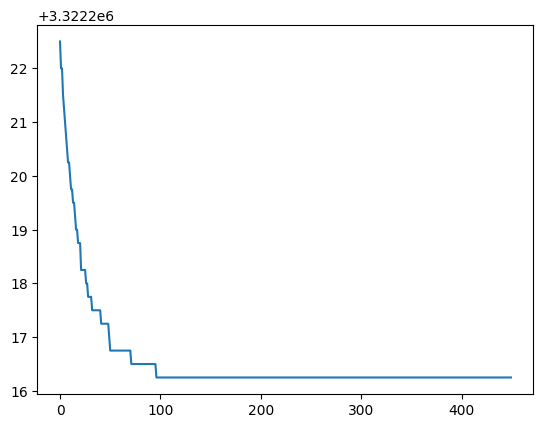

In [ ]:
_ = train_loss.plot.line()

In [ ]:
df['LSTMPredMean']

Date
1990-02-26    0.001783
1990-02-27    0.000366
1990-02-28    0.000126
1990-03-01    0.000072
1990-03-02    0.000053
                ...   
2023-02-16    0.000002
2023-02-17    0.000002
2023-02-21    0.000002
2023-02-22    0.000002
2023-02-23    0.000002
Name: LSTMPredMean, Length: 8313, dtype: float32

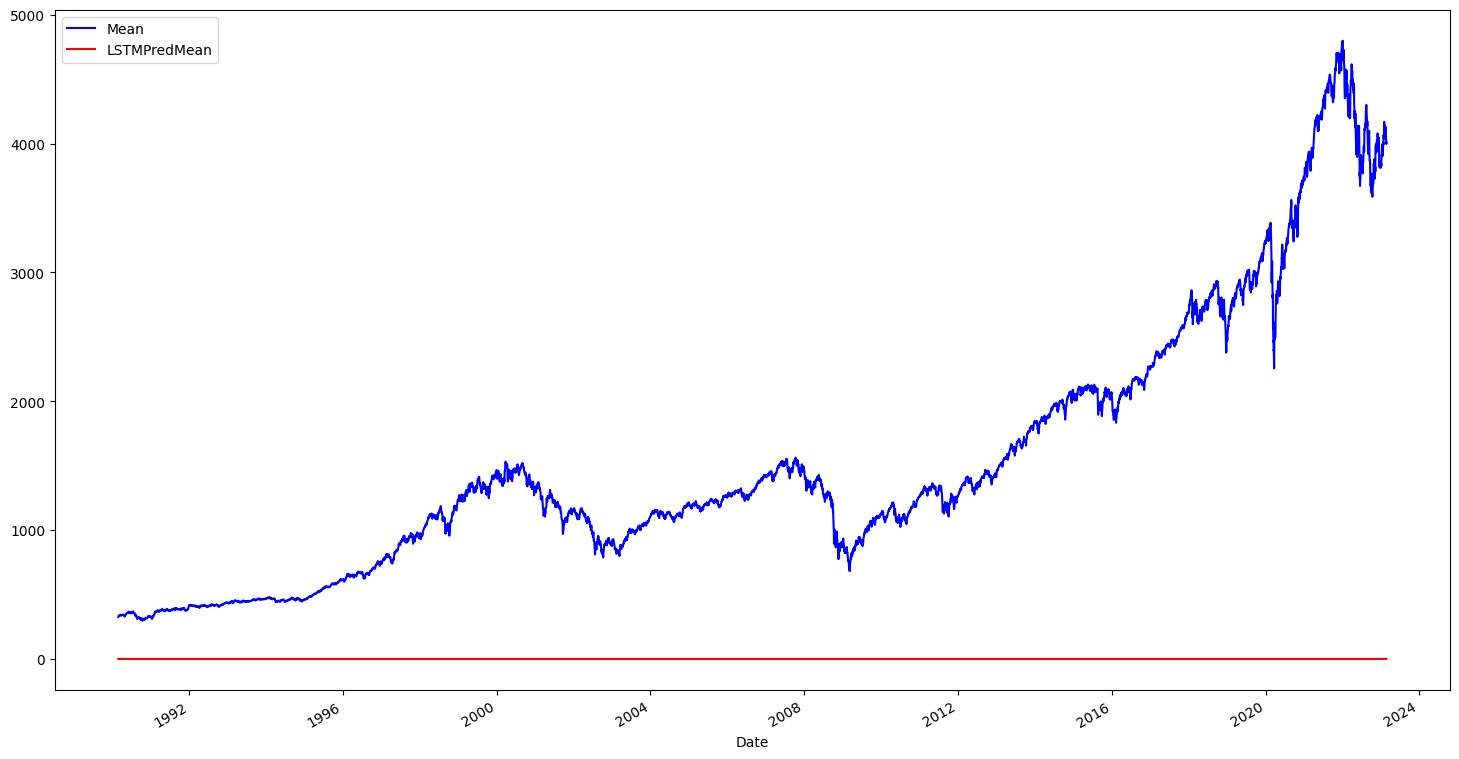

In [ ]:
df['LSTMPredMean'] = lstm_autoencoder(data).detach().cpu().numpy().squeeze()
#df['LSTMPredMean'] = lstm_decoder(lstm_encoder(data)).detach().cpu().numpy().squeeze()
_ = df[['Mean', 'LSTMPredMean']].plot(color=['b', 'r'], figsize=(18, 10))